## Fonksyon Tanımları
### Öncelikle bu deneyi gerçekleştirmek için gereken fonksyonları tanımlayarak başlıyalım

### 1) Bir Önceki Ödevden iyileştirilmiş okuma ve yazma fonksyonları

In [1]:
import numpy as np
from matplotlib import pyplot as plt
%matplotlib inline

In [4]:
#first we define the write function for pgm it is important that we feed the pixel values as chars
def mypgmwrite(name,w,h,res,pixels):
    with open(str(name),'w', newline='\n',encoding='iso-8859-1') as mypgm:
        mypgm.write('P5') 
        mypgm.write('\n')
        mypgm.write(str(w)) 
        mypgm.write(' ') 
        mypgm.write(str(h)) 
        mypgm.write('\n') 
        mypgm.write(str(res)) 
        mypgm.write('\n') 

        for x in range(0,h):
            for y in range(0,w):
                mypgm.write(chr(pixels[x][y]))
        
        mypgm.close()
    

In [5]:
def mypgmread(name):
    with open(str(name),'rb') as mypgm:
        file = mypgm.read()
        header=''
        width=''
        height=''
        resolution=''
        #Data type is first two characters followed by end line
        for x in range (0,2):
            header=header+chr(file[x])
        # Check for comments starting from third character
        # We also need to itarete once more after each variable to get trough line breaks
        x=3
        if (chr(file[x])=='#'):
            comment = True
            while comment:
                if (chr(file[x])=='\n')and(chr(file[x+1])!='#'):
                    comment = False
                x = x+1
        # Width an Height are seperated by white space. 
        while (chr(file[x])!=' '):
            width = width+chr(file[x])
            x = x+1
        x = x+1
        while(chr(file[x])!='\n'):
            height = height+chr(file[x])
            x = x+1
        x = x+1
        while(chr(file[x])!='\n'):
            resolution = resolution+chr(file[x])
            x = x+1
        x = x+1
        
        bytepixels = file[x:]
        pixels = list(bytepixels)
        mypgm.close()
    return name,int(width),int(height),int(resolution),pixels

### 2) Negatif Alma Fonksyonu

In [6]:
#first processing functions is to obtain the negative of the image. Done by inverting the gray values.
def mypgmnegative(pixels):
    pixels=255-pixels
    return pixels

### 3) Logaritmik Transform

In [46]:
#s = c log(1 + r)
def mypgmlogtransform(c,pixels):
    
    pixels = np.array(pixels)
    pixels = pixels.astype(int)
    for s in range(len(pixels)):
        pixels[s]=c*np.log(1+pixels[s])

    
    return pixels

### 4) Gamma Güç Fonksyonu

In [148]:
#s = cr^g
def mypgmgammapower(c,gamma,pixels):
    pixels=c*pow(pixels,gamma)
    return pixels

### 5) Correlation Filter Fonksyonu

#### Kodun bu kısmında maskeyi oluşturup pixel değerlerini belirleyen ve bu değerleri görsele işleyen iki farklı fonksyon oluşturmak kodu yazmayı ve okumayı kolaylaştırdı. İlk fonksyon(correlationloop) maske oluşturup pixel değerlerini belirliyor. Bu fonksyonun maske oluşturma kısmını daha sonra median filter oluşturmak için yeniden kullandım. ikinci kısım ise(correlationfilter) ilk fonksyondan aldığı değerleri imaj değerlerine işliyor.

In [16]:
def correlationloop(size,fix1,fix2,pixels):
    #for this lab we will only use square masks 
    size2=size
    mask = np.array([0]*(size*size))
    mask = np.reshape(mask,(size,size2))
    #Define the constants we will use in loops for example if the mask is 3x3 we should get the values from positions (-1,-1)to(1,1) from center
    #If we do not cast values to integers for loop will give us headaches
    boundry1=((size-1)/2)
    boundry1=int(boundry1)
    boundry2=((size2-1)/2)
    boundry2=int(boundry2)
    x,y=pixels.shape
    for i in range(size):
        for j in range (size2):
            if((fix1-boundry1+i)>x) and ((fix2-boundry2+j)>y): #To assign zero if the mask value position is not greater than our pixel array
                mask[i][j]=0
            if((fix1-boundry1+i)>=0) and ((fix2-boundry2+j)>=0) and ((fix1-boundry1+i)<x) and ((fix2-boundry2+j)<y): #Only gets the values from original array if all within boundries 
                mask[i][j]=pixels[fix1-boundry1+i][fix2-boundry1+j]
            if((fix1-boundry1+i)<0) and ((fix2-boundry2+j)<0): #To assign zero if the mask value position is lesser than our pixel array
                mask[i][j]=0 #Later we might change this to mirroring or periodic repeating

    #This line forward calculates the avarage of the values within the mask
    smoothpixel=0
    for a in range(size):
        for b in range(size2):
            smoothpixel=smoothpixel+((mask[a][b])/(size*size2))
    smoothpixel=int(smoothpixel)
    return(smoothpixel)

In [18]:
def mypgmcorrelationfilter(size,pixels):
    #check if the mask index is odd so we can determine the center
    if ((size%2)==0):
        print('box size is not odd')
    pixels = np.array(pixels)
    pixels = np.reshape(pixels,(h,w))
    for o in range(h):
        for p in range(w):
            pixels[o][p]=correlationloop(size,o,p,pixels)
    return pixels

### 6) Median Filter Fonksyonu

#### Bu fonksyon için correlation filter ile benzer olarak maske oluşturup pixel değerlerini belirleme ve bu pixel değerlerini imaja yazma işlemlerini iki fonksyon ile yaptım. İşlemi yapmak için fonksyonlardan 2.sini çağırmak hem correlation filter hem de median filter için yeterlidir.

In [19]:
def medianfilterloop(size,fix1,fix2,pixels):
    #Mask creation is same as the correlationloop function
    size2=size
    mask = np.array([0]*(size*size))
    mask = np.reshape(mask,(size,size2))
    boundry1=((size-1)/2)
    boundry1=int(boundry1)
    boundry2=((size2-1)/2)
    boundry2=int(boundry2)
    x,y=pixels.shape
    for i in range(size):
        for j in range (size2):
            if((fix1-boundry1+i)>x) and ((fix2-boundry2+j)>y):
                mask[i][j]=0
            if((fix1-boundry1+i)>=0) and ((fix2-boundry2+j)>=0) and ((fix1-boundry1+i)<x) and ((fix2-boundry2+j)<y):
                mask[i][j]=pixels[fix1-boundry1+i][fix2-boundry1+j]
            if((fix1-boundry1+i)<0) and ((fix2-boundry2+j)<0):
                mask[i][j]=0


    #This line forward flattens and sorts the array and finds the median value
    center =((size*size2)+1)/2
    center= int(center)
    mask = mask.flatten()
    mask=sorted(mask)
    filterpixel = mask[center-1] #interestingly only this value works and oly the 3x3 size works
    return(filterpixel) 

In [20]:
def mypgmmedianfilter(size,pixels):
    #check if the mask index is odd 
    if ((size%2)==0):
        print('box size is not odd')
    pixels = np.array(pixels)
    pixels = np.reshape(pixels,(h,w))
    for o in range(h):
        for p in range(w):
            pixels[o][p]=medianfilterloop(size,o,p,pixels)
    return pixels

    

## Bu Fonksyonlara Ilgili görselleri uygulayarak çıkışlarını gözlemliyelim.

### 1) Negatif Fonksyonu

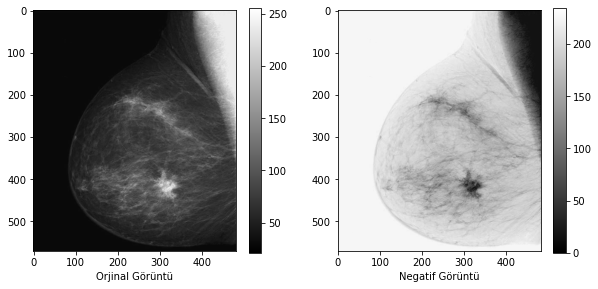

In [119]:
name,w,h,res,pixels = mypgmread('Fig0304(a)(breast_digital_Xray).pgm')
pixels = np.array(pixels)
pixels = np.reshape(pixels,(h,w))
plt.figure(figsize = (10,10))
plt.subplot(1,2,1)
plt.xlabel('Orjinal Görüntü')
plt.imshow(pixels, cmap="gray")
plt.colorbar(shrink=0.45)

pixels = mypgmnegative(pixels)
plt.subplot(1,2,2)
plt.xlabel('Negatif Görüntü')
plt.imshow(pixels, cmap="gray")
plt.colorbar(shrink=0.45)
mypgmwrite('myFig0304(a)(breast_digital_Xray).pgm',w,h,res,pixels)

#### -1 eğimli bir fonksyon ile pixel değerlerini yeniden belirliyerek görüntünün negatifini elde ettk. Belli durumlarda sadece görüntünün negatifini elde etmek bile görüntüyü iyileştirmenin bir yolu olarak kabul görebilir.

## 2) Logaritmik Transform

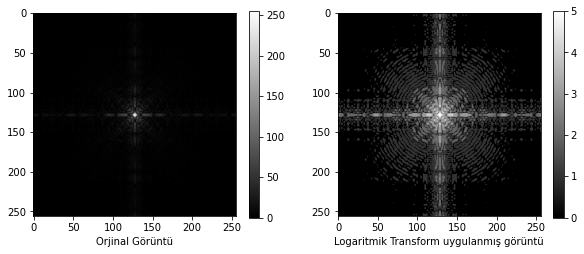

In [120]:
name,w,h,res,pixels = mypgmread('Fig0305(a)(DFT_no_log).pgm')
pixels = np.array(pixels)
pixels = np.reshape(pixels,(h,w))
plt.figure(figsize = (10,10))
plt.subplot(1,2,1)
plt.xlabel('Orjinal Görüntü')
plt.imshow(pixels, cmap="gray")
plt.colorbar(shrink=0.38)


pixels = mypgmlogtransform(1,pixels)
plt.subplot(1,2,2)
plt.xlabel('Logaritmik Transform uygulanmış görüntü')
plt.imshow(pixels, cmap="gray")
plt.colorbar(shrink=0.38)



mypgmwrite('myFig0305(a)(DFT_no_log).pgm',w,h,np.log(res),pixels)

#### Logaritmik transform görselin dinamik aralığını düşürdüğü için daha karanlık bölgeler daha aydınlık, çok aydınlık bölgeler daha karanlık, yani görselin renk yoğunluğu daha dengeli gözükmektedir. Fakat görsel dosyaya işlenirken renk çözünürlüğünün yeniden ayarlanması gerektiği dikkate alınmalıdır.

## 3) Gamma Güç Fonksyonu

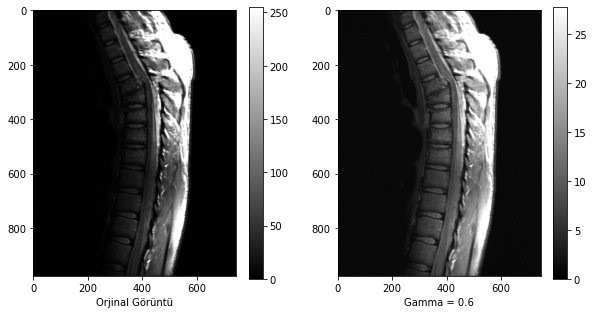

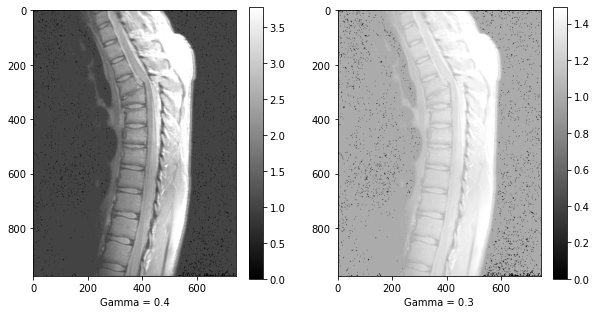

In [149]:
name,w,h,res,pixels = mypgmread('Fig0308(a)(fractured_spine).pgm')
pixels = np.array(pixels)
pixels = np.reshape(pixels,(h,w))
plt.figure(figsize = (10,10)) 
plt.subplot(1,2,1)
plt.xlabel('Orjinal Görüntü')
plt.imshow(pixels, cmap="gray")
plt.colorbar(shrink=0.50)


pixels = mypgmgammapower(1,0.6,pixels)
plt.subplot(1,2,2)
plt.xlabel('Gamma = 0.6')
plt.imshow(pixels, cmap="gray")
plt.colorbar(shrink=0.50)




pixels = mypgmgammapower(1,0.4,pixels)
plt.figure(figsize = (10,10))
plt.subplot(1,2,1)
plt.xlabel('Gamma = 0.4')
plt.imshow(pixels, cmap="gray")
plt.colorbar(shrink=0.50)


pixels = mypgmgammapower(1,0.3,pixels)
plt.subplot(1,2,2)
plt.xlabel('Gamma = 0.3')
plt.imshow(pixels, cmap="gray")
plt.colorbar(shrink=0.50)




#### Gamma fonksyonu, Logaritmik dönüşüme benzer olarak dinamik aralığı düşürerek karanlık/aydınlık bölgeleri birbirine yaklaştırmamızı sağlıyor. Fakat bu örnekte de görebiliyoruz ki, logaritmik transformdan farklı olarak gamma değerini değiştirerek değişken dinamik aralıklar elde edebiliyoruz.Yine dosyaya işlerken çözünürlüğe dikkat etmek gerekmektedir.

## 4) Correlation Filter Fonksyonu

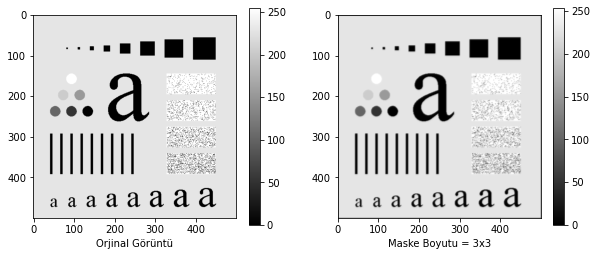

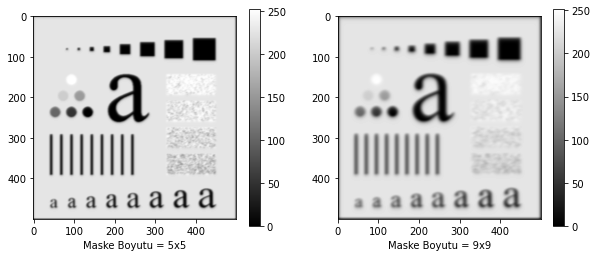

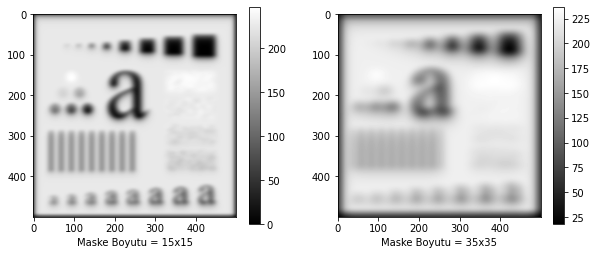

In [156]:
name,w,h,res,pixels = mypgmread('Soft.pgm')
pixels = np.array(pixels)
pixels = np.reshape(pixels,(h,w))
plt.figure(figsize = (10,10))
plt.subplot(1,2,1)
plt.xlabel('Orjinal Görüntü')
plt.imshow(pixels, cmap="gray")
plt.colorbar(shrink=0.40)

pixels = mypgmcorrelationfilter(3,pixels)
plt.subplot(1,2,2)
plt.xlabel('Maske Boyutu = 3x3')
plt.imshow(pixels, cmap="gray")
plt.colorbar(shrink=0.40)

pixels = mypgmcorrelationfilter(5,pixels)
plt.figure(figsize = (10,10))
plt.subplot(1,2,1)
plt.xlabel('Maske Boyutu = 5x5')
plt.imshow(pixels, cmap="gray")
plt.colorbar(shrink=0.40)

pixels = mypgmcorrelationfilter(9,pixels)
plt.subplot(1,2,2)
plt.xlabel('Maske Boyutu = 9x9')
plt.imshow(pixels, cmap="gray")
plt.colorbar(shrink=0.40)

pixels = mypgmcorrelationfilter(15,pixels)
plt.figure(figsize = (10,10))
plt.subplot(1,2,1)
plt.xlabel('Maske Boyutu = 15x15')
plt.imshow(pixels, cmap="gray")
plt.colorbar(shrink=0.40)

pixels = mypgmcorrelationfilter(35,pixels)
plt.subplot(1,2,2)
plt.xlabel('Maske Boyutu = 35x35')
plt.imshow(pixels, cmap="gray")
plt.colorbar(shrink=0.40)

#### Correlation filter özellikle dinamik farkın yüksek olduğu sınır bölgelerinde sınır ve etrafındaki pixel değerlerini birbirine yaklaştırdığı için görüntüyü pürüzsüzleştiren bir etkiye sahip. Her pixele etrafındaki pixellerle ortalamasının değerini atıyarak bu etkiyi sağlamaktadır. Bu çalışmada işlemciye olan yükünün de bir hayli yüksek olduğu gözlemlenmiştir. Maske boyutu arttıkça pürüzsüzleştirme etkisi de artar.

## 6) Median Filter Fonksyonu

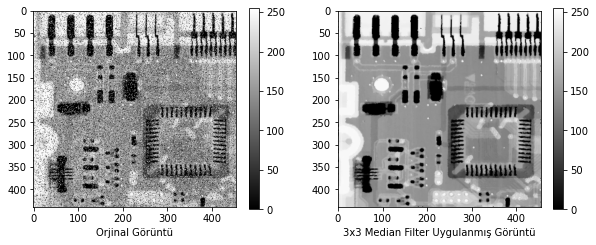

In [155]:
name,w,h,res,pixels = mypgmread('Noise.pgm')
pixels = np.array(pixels)
pixels = np.reshape(pixels,(h,w))
plt.figure(figsize = (10,10))
plt.subplot(1,2,1)
plt.xlabel('Orjinal Görüntü')
plt.imshow(pixels, cmap="gray")
plt.colorbar(shrink=0.37)

pixels = mypgmmedianfilter(3,pixels)
plt.subplot(1,2,2)
plt.xlabel('3x3 Median Filter Uygulanmış Görüntü')
plt.imshow(pixels, cmap="gray")
plt.colorbar(shrink=0.37)

#### Salt and Pepper gürültüsü olan bir görüntüden gürürltüyü bastırarak iyileştirilmiş görüntü elde etmenin en uygun yolu median filter kullanmaktır. Median filter her pixele etrafındaki pixellere kıyasla ortanca değeri atıyarak elde edilen görüntüdür. Görüntüdeki gürültünün siyah yada beyaz ağırlığına bağlı olarak ortanca değerin altı yada üstü alınabilir. Bu örnekte ilginç bir şekilde sadece 3x3 boyutunda filtre ortancanın bir altı değer seçilerek uygulandığında etkili olmuştur. Bu görseldeki gürültüde Salt(beyaz)ın daha ağırlıkta olduğunu göstermektedir.